# **Load ChEMBL data**

In [1]:
import pandas as pd

In [2]:
df = pd.read_csv('raw_CHEMBL2842_mTOR.csv',sep=";")
print(df.shape)
df.tail(3)

(4715, 45)


,Molecule ChEMBL ID,Molecule Name,Molecule Max Phase,Molecular Weight,#RO5 Violations,AlogP,Compound Key,Smiles,Standard Type,Standard Relation,Standard Value,Standard Units,pChEMBL Value,Data Validity Comment,Comment,Uo Units,Ligand Efficiency BEI,Ligand Efficiency LE,Ligand Efficiency LLE,Ligand Efficiency SEI,Potential Duplicate,Assay ChEMBL ID,Assay Description,Assay Type,BAO Format ID,BAO Label,Assay Organism,Assay Tissue ChEMBL ID,Assay Tissue Name,Assay Cell Type,Assay Subcellular Fraction,Assay Parameters,Assay Variant Accession,Assay Variant Mutation,Target ChEMBL ID,Target Name,Target Organism,Target Type,Document ChEMBL ID,Source ID,Source Description,Document Journal,Document Year,Cell ChEMBL ID,Properties
4712,CHEMBL2206921,NaN,0,470.35,0,2.49,BDBM50401261,Cc1nc(N)nc(-c2cc(Cl)cnc2Nc2cnc(Cl)c(NS(=O)(=O)...,IC50,'=',163.00,nM,6.79,NaN,255275,UO_0000065,14.43,0.31,4.30,4.47,False,CHEMBL3706289,In Vitro Inhibition Assay: The Invitrogen (Car...,B,BAO_0000357,single protein format,Homo sapiens,None,None,None,None,NaN,NaN,NaN,CHEMBL2842,Serine/threonine-protein kinase mTOR,Homo sapiens,SINGLE PROTEIN,CHEMBL3638541,37,BindingDB Database,NaN,2014,None,NaN
4713,CHEMBL3645910,NaN,0,505.00,1,3.80,BDBM116089,CCc1ncnc(-c2cc(F)c(C(=O)N3CCN4CCC[C@H]4C3)c(Cl...,IC50,'=',0.07,nM,10.15,NaN,240701,UO_0000065,20.11,0.39,6.35,11.51,False,CHEMBL3706089,mTOR Kinase Activity Assay: The mTOR kinase TR...,B,BAO_0000357,single protein format,Homo sapiens,None,None,None,None,NaN,NaN,NaN,CHEMBL2842,Serine/threonine-protein kinase mTOR,Homo sapiens,SINGLE PROTEIN,CHEMBL3638592,37,BindingDB Database,NaN,2014,None,NaN
4714,CHEMBL1081312,NaN,0,319.37,0,3.07,"78, PP121",Nc1ncnc2c1c(-c1cnc3[nH]ccc3c1)nn2C1CCCC1,IC50,'=',10.00,nM,8.00,NaN,NaN,UO_0000065,25.05,0.46,4.93,8.14,False,CHEMBL3223610,Inhibition of mTOR (unknown origin),B,BAO_0000357,single protein format,Homo sapiens,None,None,None,None,NaN,NaN,NaN,CHEMBL2842,Serine/threonine-protein kinase mTOR,Homo sapiens,SINGLE PROTEIN,CHEMBL3217752,1,Scientific Literature,MedChemComm,2012,None,NaN


In [3]:
#print(df.columns)

## **Filter data by standard units**

In [4]:
# Check if the data only has target_organism=='Homo sapiens'
print(pd.unique(df['Target Organism']))
# Filter data by target_organism=='Homo sapiens'
df=df[df['Target Organism'].isin(['Homo sapiens'])]
print(pd.unique(df['Target Organism']))
print(df.shape)

# Check if the data only has standard_type=='IC50'
print(pd.unique(df['Standard Type']))

print(pd.unique(df['Standard Units']))
# Filter data by units = ['nM','ug.mL-1','uM','pM','ug/g']
units = ['nM','ug.mL-1','uM','pM','ug/g']
df=df[df['Standard Units'].isin(units)].reset_index().drop(columns='index')

print(pd.unique(df['Standard Units']))
print(df.shape)

['Homo sapiens']
['Homo sapiens']
(4715, 45)
['IC50']
['nM' nan "10'7nM"]
['nM']
(4635, 45)


# **Data Cleaning**


* Drop missing SMILE notation
* Drop missing standard values
* Drop duplicated assays (by assay ID)


In [5]:
# Drop compounds having missing standard_value.
df2 = df[df['Standard Value'].notna()]
print(df2.shape)

# Drop compounds having missing canonical_smiles column.
df2 = df2[df['Smiles'].notna()]
print(df2.shape)

# Reset index
df2 = df2.reset_index().drop(columns='index')
print(df2.shape)
df2.head(3)

(4635, 45)
(4635, 45)
(4635, 45)


,Molecule ChEMBL ID,Molecule Name,Molecule Max Phase,Molecular Weight,#RO5 Violations,AlogP,Compound Key,Smiles,Standard Type,Standard Relation,Standard Value,Standard Units,pChEMBL Value,Data Validity Comment,Comment,Uo Units,Ligand Efficiency BEI,Ligand Efficiency LE,Ligand Efficiency LLE,Ligand Efficiency SEI,Potential Duplicate,Assay ChEMBL ID,Assay Description,Assay Type,BAO Format ID,BAO Label,Assay Organism,Assay Tissue ChEMBL ID,Assay Tissue Name,Assay Cell Type,Assay Subcellular Fraction,Assay Parameters,Assay Variant Accession,Assay Variant Mutation,Target ChEMBL ID,Target Name,Target Organism,Target Type,Document ChEMBL ID,Source ID,Source Description,Document Journal,Document Year,Cell ChEMBL ID,Properties
0,CHEMBL3931669,NaN,0,458.54,0,1.73,BDBM251585,CNc1nc2ccccc2n1-c1nc2c(c(C(C)(C)S(C)(=O)=O)n1)...,IC50,'=',588.0,nM,6.23,NaN,438481,UO_0000065,13.59,0.27,4.50,5.59,False,CHEMBL3889163,LanthaScreen Kinase Activity Assay: The enzyma...,B,BAO_0000357,single protein format,None,None,None,None,None,NaN,NaN,NaN,CHEMBL2842,Serine/threonine-protein kinase mTOR,Homo sapiens,SINGLE PROTEIN,CHEMBL3886972,37,BindingDB Database,NaN,2016,None,NaN
1,CHEMBL3646479,NaN,0,523.62,1,2.51,BDBM125321,COc1ccc(Nc2ncc(C(C)N3CCN(S(C)(=O)=O)CC3)cc2-c2...,IC50,'=',476.0,nM,6.32,NaN,255040,UO_0000065,12.07,0.23,3.81,4.45,False,CHEMBL3706289,In Vitro Inhibition Assay: The Invitrogen (Car...,B,BAO_0000357,single protein format,Homo sapiens,None,None,None,None,NaN,NaN,NaN,CHEMBL2842,Serine/threonine-protein kinase mTOR,Homo sapiens,SINGLE PROTEIN,CHEMBL3638541,37,BindingDB Database,NaN,2014,None,NaN
2,CHEMBL3701089,NaN,0,527.64,1,4.22,BDBM172223,CCc1nccc(-c2ccc(C(=O)N3CCN(C4CCOCC4)CC3)c(F)c2...,IC50,'=',5.0,nM,8.30,NaN,317147,UO_0000065,15.73,0.29,4.08,11.76,False,CHEMBL3706375,TR-FRET Assay: Kinase reaction conditions:400 ...,B,BAO_0000357,single protein format,Homo sapiens,None,None,None,None,NaN,NaN,NaN,CHEMBL2842,Serine/threonine-protein kinase mTOR,Homo sapiens,SINGLE PROTEIN,CHEMBL3639133,37,BindingDB Database,NaN,2015,None,NaN


## **Convert Standard Units**

In [6]:
#df['Molecular Weight']

In [7]:
df2 = df2.sort_values('Standard Value').reset_index().drop(columns='index')
df2[['Standard Units','Standard Value','Molecular Weight']].tail(5)

,Standard Units,Standard Value,Molecular Weight
4630,nM,100000.0,233.27
4631,nM,200000.0,254.24
4632,nM,400000.0,194.19
4633,nM,1100000.0,430.82
4634,nM,10000000.0,541.56


In [8]:
#units = ['nM','ug.mL-1','uM','pM','ug/g']

standard_unit_nM = []

for i,j,k in zip(df2['Standard Units'],df2['Standard Value'],df2['Molecular Weight']):
    if i == 'nM':
      standard_unit_nM.append(float(j))
    elif i == 'ug.mL-1':
      standard_unit_nM.append(float(1000000*float(j)/float(k)))
    elif i == 'uM':
      standard_unit_nM.append(float(1000*float(j)))
    elif i == 'pM':
      standard_unit_nM.append(float(float(j)/1000))
    elif i == 'ug/g':
      standard_unit_nM.append(float(1000000*float(j)/float(k)))



In [9]:
#standard_unit_nM
standard_value_nM = pd.Series(standard_unit_nM, name='standard_value_nM')
print(standard_value_nM.shape)
standard_value_nM.tail(3)

(4635,)


4632      400000.0
4633     1100000.0
4634    10000000.0
Name: standard_value_nM, dtype: float64

In [11]:
df3 = pd.concat([df2, standard_value_nM], axis=1)
#df3.columns
#df3[['Standard Value','Standard Units','standard_unit_nM']]

print(standard_value_nM.shape)
print(df2.shape)
print(df3.shape)

# Sort data by ascending 'standard_unit_nM' values.
df3 = df3.sort_values('standard_value_nM',ascending=True).reset_index().drop(columns='index')
#df3[['Standard Value','Standard Units','standard_value_nM', 'Molecular Weight']].loc[(df3['Standard Units']=='ug.mL-1')].tail(3)

(4635,)
(4635, 45)
(4635, 46)


## **Duplicated Compounds**

In [12]:
# Keep the one with minimum standard_value for duplicated ['compound_ID','target_ID']
df3 = df3.drop_duplicates(subset=['Molecule ChEMBL ID','Target ChEMBL ID'], keep='first').reset_index().drop(columns='index')
print(df3.shape)
df3['standard_value_nM'].head

(4194, 46)


<bound method NDFrame.head of 0              0.07
1              0.08
2              0.10
3              0.10
4              0.10
           ...     
4189      100000.00
4190      100000.00
4191      400000.00
4192     1100000.00
4193    10000000.00
Name: standard_value_nM, Length: 4194, dtype: float64>

In [13]:
# Data pre-processing
# Combine columns (molecule_chembl_id,canonical_smiles,standard_value) and bioactivity_class into a DataFrame
selection = ['Molecule ChEMBL ID','Smiles','standard_value_nM']
df4 = df3[selection].rename(columns={'Molecule ChEMBL ID':'molecule_chembl_id','Smiles':'canonical_smiles','standard_unit_nM':'standard_value'})
print(df4.shape)
df4.tail(3)

(4194, 3)


,molecule_chembl_id,canonical_smiles,standard_value_nM
4191,CHEMBL113,Cn1c(=O)c2c(ncn2C)n(C)c1=O,400000.0
4192,CHEMBL4100862,FC(F)(F)c1cc(Cl)ncc1-c1nc(N2CCOCC2)nc(N2CCOCC2)n1,1100000.0
4193,CHEMBL2087479,CS(=O)(=O)N1CCN(Cc2cn3cc(-c4cnc(N)nc4C(F)(F)F)...,10000000.0


In [14]:
# Saves to CSV 
df4.to_csv('CHEMBL2842_bioactivity_data_preprocessed.csv', index=False)

# **Labeling** 

In [16]:
import pandas as pd

df5 = pd.read_csv('CHEMBL2842_bioactivity_data_preprocessed.csv')
df5.tail(3)

,molecule_chembl_id,canonical_smiles,standard_value_nM
4191,CHEMBL113,Cn1c(=O)c2c(ncn2C)n(C)c1=O,400000.0
4192,CHEMBL4100862,FC(F)(F)c1cc(Cl)ncc1-c1nc(N2CCOCC2)nc(N2CCOCC2)n1,1100000.0
4193,CHEMBL2087479,CS(=O)(=O)N1CCN(Cc2cn3cc(-c4cnc(N)nc4C(F)(F)F)...,10000000.0


### Distribution


In [17]:
import seaborn as sns
import numpy as np
sns.set(style='ticks')
import matplotlib.pyplot as plt

In [18]:
#df5.standard_value_nM.describe()

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


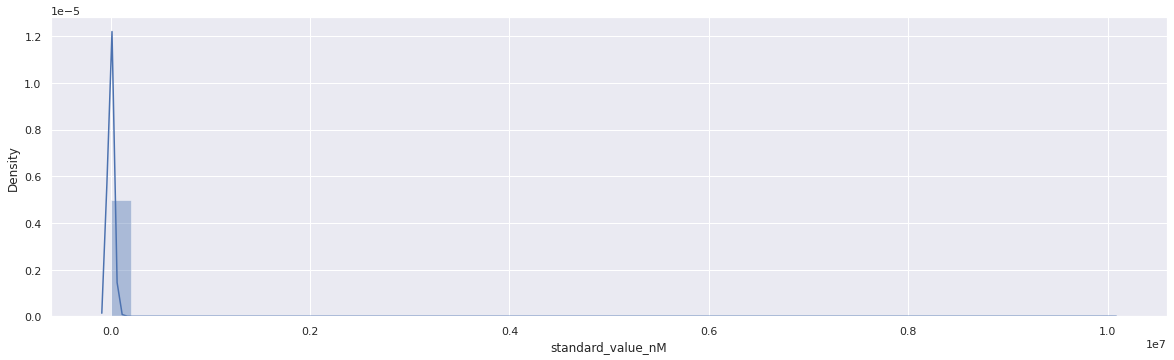

In [19]:
plt.figure(figsize=(20,5.5))
sns.set_theme(); 
ax = sns.distplot(df5['standard_value_nM'])

### Scaling (pIC50)


To allow **IC50** data to be more uniformly distributed, we will convert **IC50** to the negative logarithmic scale which is essentially **-log10(IC50)**.

This custom function pIC50() will accept a DataFrame as input and will:
* Take the IC50 values from the ``standard_value`` column and converts it from nM to M by multiplying the value by 10$^{-9}$
* Take the molar value and apply -log10
* Delete the ``standard_value`` column and create a new ``pIC50`` column

In [20]:
import numpy as np

def pIC50(input):
    pIC50 = []

    for i in input['standard_value_norm']:
        molar = i*(10**-9) # Converts nM to M
        pIC50.append(-np.log10(molar))

    input['pIC50'] = pIC50
    x = input.drop('standard_value_norm', 1)
        
    return x

In [21]:
def norm_value(input):
    norm = []

    for i in input['standard_value_nM']:
        #  Values greater than 100,000,000 will be fixed at 100,000,000 otherwise the negative logarithmic value will become negative.
        if i > 100000000:
          i = 100000000
        norm.append(i)

    input['standard_value_norm'] = norm
    x = input.drop('standard_value_nM', 1)
        
    return x

In [22]:
# Normalization
df6 = norm_value(df5)
df_norm = pIC50(df6)
df_norm.head #.pIC50.describe()

<bound method NDFrame.head of      molecule_chembl_id  ...      pIC50
0         CHEMBL3645910  ...  10.154902
1          CHEMBL558955  ...  10.096910
2             CHEMBL413  ...  10.000000
3          CHEMBL585480  ...  10.000000
4         CHEMBL1098245  ...  10.000000
...                 ...  ...        ...
4189      CHEMBL1241492  ...   4.000000
4190      CHEMBL1241680  ...   4.000000
4191          CHEMBL113  ...   3.397940
4192      CHEMBL4100862  ...   2.958607
4193      CHEMBL2087479  ...   2.000000

[4194 rows x 3 columns]>

In [23]:
#df_norm.pIC50.describe()

#### **Distribution plots**

In [24]:
botton_line = np.percentile(df_norm.pIC50, 20)
top_line = np.percentile(df_norm.pIC50, 80)
top_line
botton_line

5.729555590854652

In [25]:
'''plt.figure(figsize=(16, 4))

sns.set_theme(); 

ax = sns.distplot(df_norm['pIC50'], hist=True, color='#388E3C')
kde_x, kde_y = ax.lines[0].get_data()

#plotting the two lines
p1 = plt.axvline(x=botton_line,color='#EF9A9A')
p2 = plt.axvline(x=top_line,color='#EF9A9A')

ax.fill_between(kde_x, kde_y, where=(kde_x<botton_line) | (kde_x>top_line) , 
                interpolate=True, color='#EF9A9A')'''

"plt.figure(figsize=(16, 4))\n\nsns.set_theme(); \n\nax = sns.distplot(df_norm['pIC50'], hist=True, color='#388E3C')\nkde_x, kde_y = ax.lines[0].get_data()\n\n#plotting the two lines\np1 = plt.axvline(x=botton_line,color='#EF9A9A')\np2 = plt.axvline(x=top_line,color='#EF9A9A')\n\nax.fill_between(kde_x, kde_y, where=(kde_x<botton_line) | (kde_x>top_line) , \n                interpolate=True, color='#EF9A9A')"

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


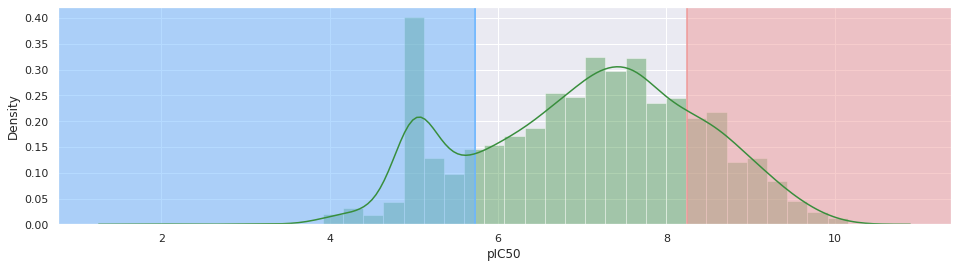

In [26]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(16, 4))

#plotting the two lines
p1 = plt.axvline(x=botton_line,color='#6DB6FF')
p2 = plt.axvline(x=top_line,color='#EF9A9A')

#plotting the PDF
ax = sns.distplot(df_norm['pIC50'], hist=True, color='#388E3C')

xlim = ax.get_xlim()
ax.axvspan(xlim[0], botton_line, color='#6DB6FF', alpha=0.5)
ax.axvspan(top_line, xlim[1], color='#EF9A9A', alpha=0.5)
#reset xlim
ax.set_xlim(xlim)
plt.show()

## **Labeling**

In [27]:
bioactivity_threshold = []
for i in df_norm.pIC50:
  if float(i) >= top_line:
    bioactivity_threshold.append("active")
  elif float(i) <= botton_line:
    bioactivity_threshold.append("inactive")
  else:
    bioactivity_threshold.append("intermediate")

In [28]:
# Combine the data
bioactivity_class = pd.Series(bioactivity_threshold, name='bioactivity_class')
df7 = pd.concat([df_norm, bioactivity_class], axis=1)
print(df7.shape)
df7.head(5)

(4194, 4)


,molecule_chembl_id,canonical_smiles,pIC50,bioactivity_class
0,CHEMBL3645910,CCc1ncnc(-c2cc(F)c(C(=O)N3CCN4CCC[C@H]4C3)c(Cl...,10.154902,active
1,CHEMBL558955,COC(=O)N1CCC(n2ncc3c(N4CCOCC4)nc(-c4ccc(NC(=O)...,10.096910,active
2,CHEMBL413,CO[C@H]1C[C@@H]2CC[C@@H](C)[C@@](O)(O2)C(=O)C(...,10.000000,active
3,CHEMBL585480,CCn1ncc2c(N3CC4CCC(C3)O4)nc(-c3ccc(NC(=O)Nc4cc...,10.000000,active
4,CHEMBL1098245,COC(=O)N1CCC(n2ncc3c(N4CCOCC4)nc(-c4ccc(NC(=O)...,10.000000,active


In [29]:
print(
    ' active',df7['bioactivity_class'][df7['bioactivity_class']=="active"].count(),'\n',
    'inactive',df7['bioactivity_class'][df7['bioactivity_class']=="inactive"].count(),'\n',
    'intermediate',df7['bioactivity_class'][df7['bioactivity_class']=="intermediate"].count()
)

 active 839 
 inactive 839 
 intermediate 2516


Saves dataframe to CSV file

In [30]:
df7.to_csv('CHEMBL2842_bioactivity_data_curated.csv', index=False)

# **Removing 'intermediate' class**

In [35]:
df_2class = df7[df7['bioactivity_class'] != 'intermediate']
df_2class.tail(3)

,molecule_chembl_id,canonical_smiles,pIC50,bioactivity_class
4191,CHEMBL113,Cn1c(=O)c2c(ncn2C)n(C)c1=O,3.397940,inactive
4192,CHEMBL4100862,FC(F)(F)c1cc(Cl)ncc1-c1nc(N2CCOCC2)nc(N2CCOCC2)n1,2.958607,inactive
4193,CHEMBL2087479,CS(=O)(=O)N1CCN(Cc2cn3cc(-c4cnc(N)nc4C(F)(F)F)...,2.000000,inactive


In [39]:
df_2class.to_csv('CHEMBL2842_2classes_data.csv', index=False)

# **Exporatory Data Analysis**

## **Install conda and rdkit**

In [43]:
# Install conda and rdkit
! wget https://repo.anaconda.com/miniconda/Miniconda3-py37_4.8.2-Linux-x86_64.sh
! chmod +x Miniconda3-py37_4.8.2-Linux-x86_64.sh
! bash ./Miniconda3-py37_4.8.2-Linux-x86_64.sh -b -f -p /usr/local
! conda install -c rdkit rdkit -y
import sys
sys.path.append('/usr/local/lib/python3.7/site-packages/')

--2021-04-08 18:50:08--  https://repo.anaconda.com/miniconda/Miniconda3-py37_4.8.2-Linux-x86_64.sh
Resolving repo.anaconda.com (repo.anaconda.com)... 104.16.131.3, 104.16.130.3, 2606:4700::6810:8203, ...
Connecting to repo.anaconda.com (repo.anaconda.com)|104.16.131.3|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 85055499 (81M) [application/x-sh]
Saving to: ‘Miniconda3-py37_4.8.2-Linux-x86_64.sh’

Miniconda3-py37_4.8 100%[===================>]  81.12M   129MB/s    in 0.6s    

2021-04-08 18:50:09 (129 MB/s) - ‘Miniconda3-py37_4.8.2-Linux-x86_64.sh’ saved [85055499/85055499]

PREFIX=/usr/local
Unpacking payload ...
Solving environment: - done

## Package Plan ##

  environment location: /usr/local

  added / updated specs:
    - _libgcc_mutex==0.1=main
    - asn1crypto==1.3.0=py37_0
    - ca-certificates==2020.1.1=0
    - certifi==2019.11.28=py37_0
    - cffi==1.14.0=py37h2e261b9_0
    - chardet==3.0.4=py37_1003
    - conda-package-handling==1.6.0=py37h7b64

## **Lipinski 5-rule descriptors**


In [44]:
import pandas as pd

In [45]:
df = pd.read_csv('CHEMBL2842_2classes_data.csv')
df.tail(4)

,molecule_chembl_id,canonical_smiles,pIC50,bioactivity_class
1674,CHEMBL1241680,CC(C)n1nc(-c2ccc(F)c(C#N)c2)c2c(N)ncnc21,4.000000,inactive
1675,CHEMBL113,Cn1c(=O)c2c(ncn2C)n(C)c1=O,3.397940,inactive
1676,CHEMBL4100862,FC(F)(F)c1cc(Cl)ncc1-c1nc(N2CCOCC2)nc(N2CCOCC2)n1,2.958607,inactive
1677,CHEMBL2087479,CS(=O)(=O)N1CCN(Cc2cn3cc(-c4cnc(N)nc4C(F)(F)F)...,2.000000,inactive


### **Import libraries**

In [46]:
import numpy as np
from rdkit import Chem
from rdkit.Chem import Descriptors, Lipinski

### **Calculate descriptors**

In [47]:
# Inspired by: https://codeocean.com/explore/capsules?query=tag:data-curation

def lipinski(smiles, verbose=False):

    moldata= []
    for elem in smiles:
        mol=Chem.MolFromSmiles(elem) 
        moldata.append(mol)
       
    baseData= np.arange(1,1)
    i=0  
    for mol in moldata:        
       
        desc_MolWt = Descriptors.MolWt(mol)
        desc_MolLogP = Descriptors.MolLogP(mol)
        desc_NumHDonors = Lipinski.NumHDonors(mol)
        desc_NumHAcceptors = Lipinski.NumHAcceptors(mol)
           
        row = np.array([desc_MolWt,
                        desc_MolLogP,
                        desc_NumHDonors,
                        desc_NumHAcceptors])   
    
        if(i==0):
            baseData=row
        else:
            baseData=np.vstack([baseData, row])
        i=i+1      
    
    columnNames=["MW","LogP","NumHDonors","NumHAcceptors"]   
    descriptors = pd.DataFrame(data=baseData,columns=columnNames)
    
    return descriptors

In [48]:
df_lipinski = lipinski(df.canonical_smiles)
df_lipinski

,MW,LogP,NumHDonors,NumHAcceptors
0,504.997,3.79570,1.0,6.0
1,586.653,3.86950,3.0,10.0
2,914.187,6.18060,3.0,13.0
3,513.602,4.05960,3.0,8.0
4,600.680,3.91200,3.0,10.0
...,...,...,...,...
1673,295.306,2.19260,1.0,8.0
1674,296.309,2.66718,1.0,6.0
1675,194.194,-1.02930,0.0,6.0
1676,430.818,2.27900,0.0,8.0


In [49]:
df_combined = pd.concat([df,df_lipinski], axis=1)

df_combined

,molecule_chembl_id,canonical_smiles,pIC50,bioactivity_class,MW,LogP,NumHDonors,NumHAcceptors
0,CHEMBL3645910,CCc1ncnc(-c2cc(F)c(C(=O)N3CCN4CCC[C@H]4C3)c(Cl...,10.154902,active,504.997,3.79570,1.0,6.0
1,CHEMBL558955,COC(=O)N1CCC(n2ncc3c(N4CCOCC4)nc(-c4ccc(NC(=O)...,10.096910,active,586.653,3.86950,3.0,10.0
2,CHEMBL413,CO[C@H]1C[C@@H]2CC[C@@H](C)[C@@](O)(O2)C(=O)C(...,10.000000,active,914.187,6.18060,3.0,13.0
3,CHEMBL585480,CCn1ncc2c(N3CC4CCC(C3)O4)nc(-c3ccc(NC(=O)Nc4cc...,10.000000,active,513.602,4.05960,3.0,8.0
4,CHEMBL1098245,COC(=O)N1CCC(n2ncc3c(N4CCOCC4)nc(-c4ccc(NC(=O)...,10.000000,active,600.680,3.91200,3.0,10.0
...,...,...,...,...,...,...,...,...
1673,CHEMBL1241492,CC(C)n1nc(-c2ccc3nonc3c2)c2c(N)ncnc21,4.000000,inactive,295.306,2.19260,1.0,8.0
1674,CHEMBL1241680,CC(C)n1nc(-c2ccc(F)c(C#N)c2)c2c(N)ncnc21,4.000000,inactive,296.309,2.66718,1.0,6.0
1675,CHEMBL113,Cn1c(=O)c2c(ncn2C)n(C)c1=O,3.397940,inactive,194.194,-1.02930,0.0,6.0
1676,CHEMBL4100862,FC(F)(F)c1cc(Cl)ncc1-c1nc(N2CCOCC2)nc(N2CCOCC2)n1,2.958607,inactive,430.818,2.27900,0.0,8.0


In [50]:
df_combined.to_csv('CHEMBL2842_2classes_lipinski_EDA_data.csv', index=False)

## **Chemical Space Analysis**

### **Import library**

In [51]:
import seaborn as sns
sns.set(style='ticks')
import matplotlib.pyplot as plt

**Statistical analysis | Mann-Whitney U Test**

In [52]:
def mannwhitney(descriptor, verbose=False):
  # https://machinelearningmastery.com/nonparametric-statistical-significance-tests-in-python/
  from numpy.random import seed
  from numpy.random import randn
  from scipy.stats import mannwhitneyu

# seed the random number generator
  seed(1)

# actives and inactives
  selection = [descriptor, 'bioactivity_class']
  df = df_combined[selection]
  active = df[df.bioactivity_class == 'active']
  active = active[descriptor]

  selection = [descriptor, 'bioactivity_class']
  df = df_combined[selection]
  inactive = df[df.bioactivity_class == 'inactive']
  inactive = inactive[descriptor]

# compare samples
  stat, p = mannwhitneyu(active, inactive)
  #print('Statistics=%.3f, p=%.3f' % (stat, p))

# interpret
  alpha = 0.05
  if p > alpha:
    interpretation = 'Same distribution (fail to reject H0)'
  else:
    interpretation = 'Different distribution (reject H0)'
  
  results = pd.DataFrame({'Descriptor':descriptor,
                          'Statistics':stat,
                          'p':p,
                          'alpha':alpha,
                          'Interpretation':interpretation}, index=[0])
  filename = 'CHEMBL2842_mTOR_mannwhitneyu_' + descriptor + '.csv'
  results.to_csv(filename)

  return results

### **Scatter plot of MW versus LogP**



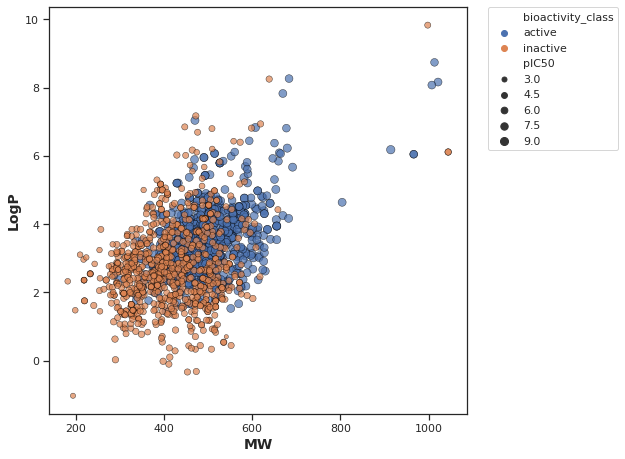

In [53]:
plt.figure(figsize=(7.5, 7.5))

sns.scatterplot(x='MW', y='LogP', data=df_combined, hue='bioactivity_class', size='pIC50', edgecolor='black', alpha=0.7)

plt.xlabel('MW', fontsize=14, fontweight='bold')
plt.ylabel('LogP', fontsize=14, fontweight='bold')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)
plt.savefig('CHEMBL2842_mTOR_plot_MW_vs_LogP.pdf')

### **Box plots &　Hypothesis Test**

#### **MW**

Text(0, 0.5, 'pIC50 value')

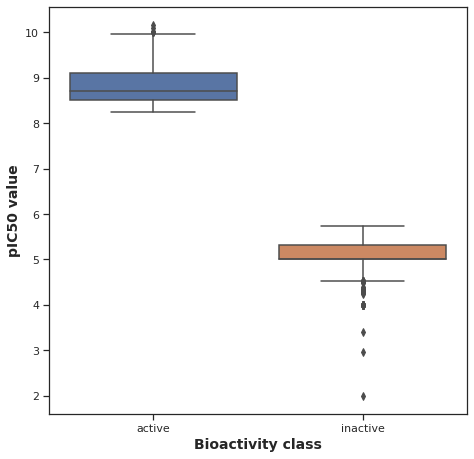

In [54]:
plt.figure(figsize=(7.5, 7.5))

sns.boxplot(x = 'bioactivity_class', y = 'pIC50', data = df_combined)

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('pIC50 value', fontsize=14, fontweight='bold')

#plt.savefig('CHEMBL2842_mTOR_plot_ic50.pdf')

In [55]:
mannwhitney('MW')

,Descriptor,Statistics,p,alpha,Interpretation
0,MW,158256.5,3.840954e-85,0.05,Different distribution (reject H0)


#### **LogP**

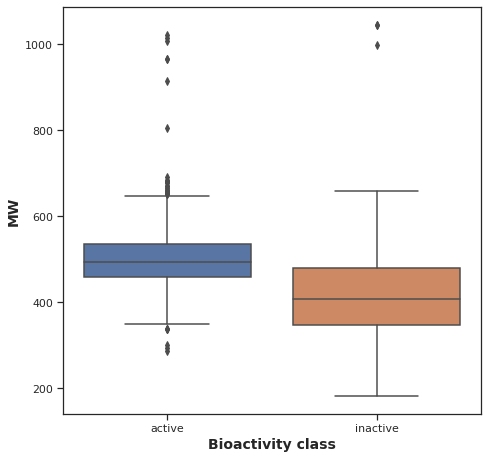

In [56]:
plt.figure(figsize=(7.5, 7.5))

sns.boxplot(x = 'bioactivity_class', y = 'MW', data = df_combined)

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('MW', fontsize=14, fontweight='bold')

plt.savefig('CHEMBL2842_mTOR_plot_MW.pdf')

#### **NumHDonors**

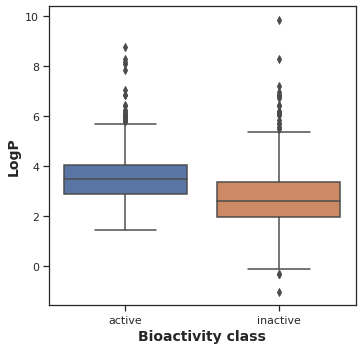

In [57]:
plt.figure(figsize=(5.5, 5.5))

sns.boxplot(x = 'bioactivity_class', y = 'LogP', data = df_combined)

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('LogP', fontsize=14, fontweight='bold')

plt.savefig('CHEMBL2842_mTOR_plot_LogP.pdf')

In [58]:
mannwhitney('NumHDonors')

,Descriptor,Statistics,p,alpha,Interpretation
0,NumHDonors,342456.0,0.153764,0.05,Same distribution (fail to reject H0)


#### **NumHAcceptors**

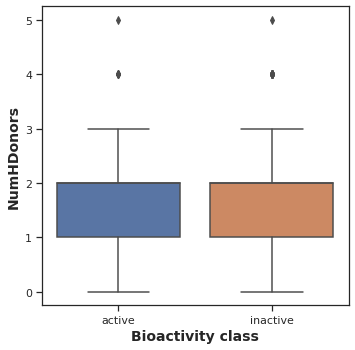

In [59]:
plt.figure(figsize=(5.5, 5.5))

sns.boxplot(x = 'bioactivity_class', y = 'NumHDonors', data = df_combined)

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('NumHDonors', fontsize=14, fontweight='bold')

plt.savefig('CHEMBL2842_mTOR_plot_NumHDonors.pdf')

In [60]:
mannwhitney('NumHAcceptors')

,Descriptor,Statistics,p,alpha,Interpretation
0,NumHAcceptors,301833.5,1.480073e-07,0.05,Different distribution (reject H0)


# **Zip files**

In [61]:
! zip -r results.zip . -i *.csv *.pdf

  adding: CHEMBL2842_mTOR_mannwhitneyu_MW.csv (deflated 8%)
  adding: CHEMBL2842_mTOR_plot_MW_vs_LogP.pdf (deflated 3%)
  adding: CHEMBL2842_mTOR_mannwhitneyu_NumHAcceptors.csv (deflated 11%)
  adding: CHEMBL2842_mTOR_plot_LogP.pdf (deflated 37%)
  adding: CHEMBL2842_bioactivity_data_curated.csv (deflated 83%)
  adding: CHEMBL2842_mTOR_plot_MW.pdf (deflated 39%)
  adding: CHEMBL2842_2classes_lipinski_EDA_data.csv (deflated 79%)
  adding: CHEMBL2842_2classes_data.csv (deflated 83%)
  adding: CHEMBL2842_mTOR_mannwhitneyu_NumHDonors.csv (deflated 10%)
  adding: CHEMBL2842_mTOR_plot_NumHDonors.pdf (deflated 39%)
  adding: raw_CHEMBL2842_mTOR.csv (deflated 88%)
  adding: CHEMBL2842_bioactivity_data_preprocessed.csv (deflated 82%)


# **Calculate fingerprint descriptors**

## **Download PaDEL-Descriptor**

In [62]:
! wget http://www.yapcwsoft.com/dd/padeldescriptor/PaDEL-Descriptor.zip

--2021-04-08 18:52:17--  http://www.yapcwsoft.com/dd/padeldescriptor/PaDEL-Descriptor.zip
Resolving www.yapcwsoft.com (www.yapcwsoft.com)... 118.189.195.172
Connecting to www.yapcwsoft.com (www.yapcwsoft.com)|118.189.195.172|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 20875190 (20M) [application/zip]
Saving to: ‘PaDEL-Descriptor.zip’

PaDEL-Descriptor.zi 100%[===================>]  19.91M  10.1MB/s    in 2.0s    

2021-04-08 18:52:19 (10.1 MB/s) - ‘PaDEL-Descriptor.zip’ saved [20875190/20875190]



In [63]:
! unzip PaDEL-Descriptor.zip

Archive:  PaDEL-Descriptor.zip
  inflating: Descriptors.xls         
  inflating: descriptors.xml         
   creating: lib/
  inflating: lib/ambit2-base-2.4.7-SNAPSHOT.jar  
  inflating: lib/ambit2-core-2.4.7-SNAPSHOT.jar  
  inflating: lib/ambit2-smarts-2.4.7-SNAPSHOT.jar  
  inflating: lib/appframework-1.0.3.jar  
  inflating: lib/cdk-1.4.15.jar      
  inflating: lib/commons-cli-1.2.jar  
  inflating: lib/guava-17.0.jar      
  inflating: lib/jama.jar            
  inflating: lib/jgrapht-0.6.0.jar   
  inflating: lib/l2fprod-common-all.jar  
  inflating: lib/libPaDEL-Descriptor.jar  
  inflating: lib/libPaDEL-Jobs.jar   
  inflating: lib/libPaDEL.jar        
  inflating: lib/swing-worker-1.1.jar  
  inflating: lib/vecmath1.2-1.14.jar  
  inflating: lib/xom-1.1.jar         
   creating: license/
  inflating: license/lgpl-2.1.txt    
  inflating: license/lgpl.license    
  inflating: license/LICENSE.txt     
  inflating: license/README - CDK    
  inflating: PaDEL-Descriptor.jar    


In [64]:
# Modify the descriptors.xml file for calculation
import lxml.etree

# input
doc = lxml.etree.parse('descriptors.xml')
# modification
for el in doc.xpath("//Descriptor[@name!='PubchemFingerprinter']"):
  el.attrib['value'] = 'false'
# output
# open('output_file.xml', 'w').write(lxml.etree.tostring(doc))
doc.write('pubchemfingerprinter.xml')

## **Load bioactivity data**

In [65]:
import pandas as pd

In [66]:
df = pd.read_csv('CHEMBL2842_2classes_lipinski_EDA_data.csv')
df.head(3)

,molecule_chembl_id,canonical_smiles,pIC50,bioactivity_class,MW,LogP,NumHDonors,NumHAcceptors
0,CHEMBL3645910,CCc1ncnc(-c2cc(F)c(C(=O)N3CCN4CCC[C@H]4C3)c(Cl...,10.154902,active,504.997,3.7957,1.0,6.0
1,CHEMBL558955,COC(=O)N1CCC(n2ncc3c(N4CCOCC4)nc(-c4ccc(NC(=O)...,10.096910,active,586.653,3.8695,3.0,10.0
2,CHEMBL413,CO[C@H]1C[C@@H]2CC[C@@H](C)[C@@](O)(O2)C(=O)C(...,10.000000,active,914.187,6.1806,3.0,13.0


In [67]:
selection = ['canonical_smiles','molecule_chembl_id']
df_selection = df[selection]
df_selection.to_csv('molecule.smi', sep='\t', index=False, header=False)

In [68]:
! cat molecule.smi | head -5

CCc1ncnc(-c2cc(F)c(C(=O)N3CCN4CCC[C@H]4C3)c(Cl)c2)c1C#Cc1ccc(N)nc1	CHEMBL3645910
COC(=O)N1CCC(n2ncc3c(N4CCOCC4)nc(-c4ccc(NC(=O)Nc5ccc(CO)cc5)cc4)nc32)CC1	CHEMBL558955
CO[C@H]1C[C@@H]2CC[C@@H](C)[C@@](O)(O2)C(=O)C(=O)N2CCCC[C@H]2C(=O)O[C@H]([C@H](C)C[C@@H]2CC[C@@H](O)[C@H](OC)C2)CC(=O)[C@H](C)/C=C(\C)[C@@H](O)[C@@H](OC)C(=O)[C@H](C)C[C@H](C)/C=C/C=C/C=C/1C	CHEMBL413
CCn1ncc2c(N3CC4CCC(C3)O4)nc(-c3ccc(NC(=O)Nc4ccc(CCO)cc4)cc3)nc21	CHEMBL585480
COC(=O)N1CCC(n2ncc3c(N4CCOCC4)nc(-c4ccc(NC(=O)Nc5ccc(CCO)cc5)cc4)nc32)CC1	CHEMBL1098245


In [69]:
! cat molecule.smi | wc -l

1678


## **Calculate PaDEL descriptors**

In [70]:
! java -Xms1G -Xmx1G -Djava.awt.headless=true -jar ./PaDEL-Descriptor.jar -removesalt -standardizenitro -fingerprints -descriptortypes ./pubchemfingerprinter.xml -dir ./ -file binary_descriptors_output.csv

Processing CHEMBL3645910 in molecule.smi (1/1678). 
Processing CHEMBL558955 in molecule.smi (2/1678). 
Processing CHEMBL413 in molecule.smi (3/1678). Average speed: 8.12 s/mol.
Processing CHEMBL585480 in molecule.smi (4/1678). Average speed: 4.30 s/mol.
Processing CHEMBL1098245 in molecule.smi (5/1678). Average speed: 3.58 s/mol.
Processing CHEMBL1091714 in molecule.smi (6/1678). Average speed: 2.87 s/mol.
Processing CHEMBL566216 in molecule.smi (7/1678). Average speed: 3.01 s/mol.
Processing CHEMBL566004 in molecule.smi (8/1678). Average speed: 2.11 s/mol.
Processing CHEMBL573157 in molecule.smi (9/1678). Average speed: 1.89 s/mol.
Processing CHEMBL600368 in molecule.smi (10/1678). Average speed: 1.92 s/mol.
Processing CHEMBL600367 in molecule.smi (11/1678). Average speed: 1.58 s/mol.
Processing CHEMBL604123 in molecule.smi (12/1678). Average speed: 1.46 s/mol.
Processing CHEMBL1801204 in molecule.smi (13/1678). Average speed: 1.38 s/mol.
Processing CHEMBL1091358 in molecule.smi (14/1

In [71]:
! ls -l

total 114564
-rw-r--r-- 1 root root  2994577 Apr  8 18:58 binary_descriptors_output.csv
-rw-r--r-- 1 root root   160548 Apr  8 18:48 CHEMBL2842_2classes_data.csv
-rw-r--r-- 1 root root   232239 Apr  8 18:51 CHEMBL2842_2classes_lipinski_EDA_data.csv
-rw-r--r-- 1 root root   424770 Apr  8 18:44 CHEMBL2842_bioactivity_data_curated.csv
-rw-r--r-- 1 root root   333912 Apr  8 18:41 CHEMBL2842_bioactivity_data_preprocessed.csv
-rw-r--r-- 1 root root      122 Apr  8 18:51 CHEMBL2842_mTOR_mannwhitneyu_MW.csv
-rw-r--r-- 1 root root      133 Apr  8 18:51 CHEMBL2842_mTOR_mannwhitneyu_NumHAcceptors.csv
-rw-r--r-- 1 root root      131 Apr  8 18:51 CHEMBL2842_mTOR_mannwhitneyu_NumHDonors.csv
-rw-r--r-- 1 root root    14290 Apr  8 18:51 CHEMBL2842_mTOR_plot_LogP.pdf
-rw-r--r-- 1 root root    13571 Apr  8 18:51 CHEMBL2842_mTOR_plot_MW.pdf
-rw-r--r-- 1 root root   302839 Apr  8 18:51 CHEMBL2842_mTOR_plot_MW_vs_LogP.pdf
-rw-r--r-- 1 root root    14621 Apr  8 18:51 CHEMBL2842_mTOR_plot_NumHDonors.pdf
-rw-

# **Preparing the X and Y Data Matrices**

## **X data matrix**

In [72]:
df_X = pd.read_csv('binary_descriptors_output.csv')
df_X.head(5)

,Name,PubchemFP0,PubchemFP1,PubchemFP2,PubchemFP3,PubchemFP4,PubchemFP5,PubchemFP6,PubchemFP7,PubchemFP8,PubchemFP9,PubchemFP10,PubchemFP11,PubchemFP12,PubchemFP13,PubchemFP14,PubchemFP15,PubchemFP16,PubchemFP17,PubchemFP18,PubchemFP19,PubchemFP20,PubchemFP21,PubchemFP22,PubchemFP23,PubchemFP24,PubchemFP25,PubchemFP26,PubchemFP27,PubchemFP28,PubchemFP29,PubchemFP30,PubchemFP31,PubchemFP32,PubchemFP33,PubchemFP34,PubchemFP35,PubchemFP36,PubchemFP37,PubchemFP38,...,PubchemFP841,PubchemFP842,PubchemFP843,PubchemFP844,PubchemFP845,PubchemFP846,PubchemFP847,PubchemFP848,PubchemFP849,PubchemFP850,PubchemFP851,PubchemFP852,PubchemFP853,PubchemFP854,PubchemFP855,PubchemFP856,PubchemFP857,PubchemFP858,PubchemFP859,PubchemFP860,PubchemFP861,PubchemFP862,PubchemFP863,PubchemFP864,PubchemFP865,PubchemFP866,PubchemFP867,PubchemFP868,PubchemFP869,PubchemFP870,PubchemFP871,PubchemFP872,PubchemFP873,PubchemFP874,PubchemFP875,PubchemFP876,PubchemFP877,PubchemFP878,PubchemFP879,PubchemFP880
0,CHEMBL3645910,1,1,1,0,0,0,0,0,0,1,1,1,1,0,1,1,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,CHEMBL558955,1,1,1,1,0,0,0,0,0,1,1,1,1,0,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,CHEMBL585480,1,1,1,0,0,0,0,0,0,1,1,1,1,0,1,1,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,CHEMBL413,1,1,1,1,0,0,0,0,0,1,1,1,1,1,1,0,0,0,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,CHEMBL1098245,1,1,1,1,0,0,0,0,0,1,1,1,1,0,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [73]:
df_X = df_X.drop(columns=['Name'])
print(df_X.shape)
df_X.head(3)

(1678, 881)


,PubchemFP0,PubchemFP1,PubchemFP2,PubchemFP3,PubchemFP4,PubchemFP5,PubchemFP6,PubchemFP7,PubchemFP8,PubchemFP9,PubchemFP10,PubchemFP11,PubchemFP12,PubchemFP13,PubchemFP14,PubchemFP15,PubchemFP16,PubchemFP17,PubchemFP18,PubchemFP19,PubchemFP20,PubchemFP21,PubchemFP22,PubchemFP23,PubchemFP24,PubchemFP25,PubchemFP26,PubchemFP27,PubchemFP28,PubchemFP29,PubchemFP30,PubchemFP31,PubchemFP32,PubchemFP33,PubchemFP34,PubchemFP35,PubchemFP36,PubchemFP37,PubchemFP38,PubchemFP39,...,PubchemFP841,PubchemFP842,PubchemFP843,PubchemFP844,PubchemFP845,PubchemFP846,PubchemFP847,PubchemFP848,PubchemFP849,PubchemFP850,PubchemFP851,PubchemFP852,PubchemFP853,PubchemFP854,PubchemFP855,PubchemFP856,PubchemFP857,PubchemFP858,PubchemFP859,PubchemFP860,PubchemFP861,PubchemFP862,PubchemFP863,PubchemFP864,PubchemFP865,PubchemFP866,PubchemFP867,PubchemFP868,PubchemFP869,PubchemFP870,PubchemFP871,PubchemFP872,PubchemFP873,PubchemFP874,PubchemFP875,PubchemFP876,PubchemFP877,PubchemFP878,PubchemFP879,PubchemFP880
0,1,1,1,0,0,0,0,0,0,1,1,1,1,0,1,1,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,1,1,1,0,0,0,0,0,1,1,1,1,0,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1,1,1,0,0,0,0,0,0,1,1,1,1,0,1,1,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [75]:
df_nameX = pd.read_csv('binary_descriptors_output.csv')

## **Y variable**

In [76]:
df_Y = df['bioactivity_class']
df_Y.shape

(1678,)

## **Final dataset**

In [77]:
df_final = pd.concat([df_X,df_Y], axis=1)
print(df_final.shape)
df_final.head(3)

(1678, 882)


,PubchemFP0,PubchemFP1,PubchemFP2,PubchemFP3,PubchemFP4,PubchemFP5,PubchemFP6,PubchemFP7,PubchemFP8,PubchemFP9,PubchemFP10,PubchemFP11,PubchemFP12,PubchemFP13,PubchemFP14,PubchemFP15,PubchemFP16,PubchemFP17,PubchemFP18,PubchemFP19,PubchemFP20,PubchemFP21,PubchemFP22,PubchemFP23,PubchemFP24,PubchemFP25,PubchemFP26,PubchemFP27,PubchemFP28,PubchemFP29,PubchemFP30,PubchemFP31,PubchemFP32,PubchemFP33,PubchemFP34,PubchemFP35,PubchemFP36,PubchemFP37,PubchemFP38,PubchemFP39,...,PubchemFP842,PubchemFP843,PubchemFP844,PubchemFP845,PubchemFP846,PubchemFP847,PubchemFP848,PubchemFP849,PubchemFP850,PubchemFP851,PubchemFP852,PubchemFP853,PubchemFP854,PubchemFP855,PubchemFP856,PubchemFP857,PubchemFP858,PubchemFP859,PubchemFP860,PubchemFP861,PubchemFP862,PubchemFP863,PubchemFP864,PubchemFP865,PubchemFP866,PubchemFP867,PubchemFP868,PubchemFP869,PubchemFP870,PubchemFP871,PubchemFP872,PubchemFP873,PubchemFP874,PubchemFP875,PubchemFP876,PubchemFP877,PubchemFP878,PubchemFP879,PubchemFP880,bioactivity_class
0,1,1,1,0,0,0,0,0,0,1,1,1,1,0,1,1,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,active
1,1,1,1,1,0,0,0,0,0,1,1,1,1,0,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,active
2,1,1,1,0,0,0,0,0,0,1,1,1,1,0,1,1,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,active


In [78]:
df_name_final = pd.concat([df_nameX,df_Y], axis=1)
print(df_name_final.shape)
df_name_final.head(3)

(1678, 883)


,Name,PubchemFP0,PubchemFP1,PubchemFP2,PubchemFP3,PubchemFP4,PubchemFP5,PubchemFP6,PubchemFP7,PubchemFP8,PubchemFP9,PubchemFP10,PubchemFP11,PubchemFP12,PubchemFP13,PubchemFP14,PubchemFP15,PubchemFP16,PubchemFP17,PubchemFP18,PubchemFP19,PubchemFP20,PubchemFP21,PubchemFP22,PubchemFP23,PubchemFP24,PubchemFP25,PubchemFP26,PubchemFP27,PubchemFP28,PubchemFP29,PubchemFP30,PubchemFP31,PubchemFP32,PubchemFP33,PubchemFP34,PubchemFP35,PubchemFP36,PubchemFP37,PubchemFP38,...,PubchemFP842,PubchemFP843,PubchemFP844,PubchemFP845,PubchemFP846,PubchemFP847,PubchemFP848,PubchemFP849,PubchemFP850,PubchemFP851,PubchemFP852,PubchemFP853,PubchemFP854,PubchemFP855,PubchemFP856,PubchemFP857,PubchemFP858,PubchemFP859,PubchemFP860,PubchemFP861,PubchemFP862,PubchemFP863,PubchemFP864,PubchemFP865,PubchemFP866,PubchemFP867,PubchemFP868,PubchemFP869,PubchemFP870,PubchemFP871,PubchemFP872,PubchemFP873,PubchemFP874,PubchemFP875,PubchemFP876,PubchemFP877,PubchemFP878,PubchemFP879,PubchemFP880,bioactivity_class
0,CHEMBL3645910,1,1,1,0,0,0,0,0,0,1,1,1,1,0,1,1,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,active
1,CHEMBL558955,1,1,1,1,0,0,0,0,0,1,1,1,1,0,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,active
2,CHEMBL585480,1,1,1,0,0,0,0,0,0,1,1,1,1,0,1,1,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,active


In [79]:
df_final.to_csv('CHEMBL2842_mTOR_2class_pubchem_fp.csv', index=False)

In [80]:
df_name_final.to_csv('CHEMBL2842_mTOR_2className_pubchem_fp.csv', index=False)